In [1]:
import multiprocessing as mp
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import mabs

sns.set_theme()

n = 1000
combinations = [[0.1, -0.1], [0.1, -0.2], [0.1, 0.2]]
nus = np.linspace(-0.5, 0.5, 100)

In [2]:
def experiment(a, b, nu, n):
    exp_regret = np.empty(1000)
    for i in range(1000):
        arms = [
            mabs.arms.contextual.LinearArm(nu, a),
            mabs.arms.contextual.LinearArm(nu, b),
        ]
        env = mabs.envs.contextual.LinearUCB(n, 0.1, arms)

        for _ in range(n):
            env.act()
        exp_regret[i] = env.regret
    return exp_regret

In [3]:
regrets = []
args = []

for a, b in combinations:
    args += [(a, b, nu, n) for nu in nus]
with mp.Pool(32) as p:
    result = p.starmap(experiment, args)
    regrets.append(result)

with open("result.pkl", "wb") as f:
    pickle.dump(regrets, f)

KeyboardInterrupt: 

In [3]:
with open("result.pkl", "rb") as f:
    result_raw = np.array(pickle.load(f)).squeeze()

In [4]:
result = {}
for i, combination in enumerate(combinations):
    result[str(combination)] = result_raw[i * len(nus) : (i + 1) * len(nus)]

In [5]:
result_expectation = pd.DataFrame({k: result[k].mean(axis=1) for k in result})
result_expectation["nu"] = nus
result_expectation = result_expectation.melt(
    id_vars="nu", var_name="arms", value_name="mean regret"
)

result_variance = pd.DataFrame({k: result[k].var(axis=1) for k in result})
result_variance["nu"] = nus
result_variance = result_variance.melt(
    id_vars="nu", var_name="arms", value_name="regret variance"
)

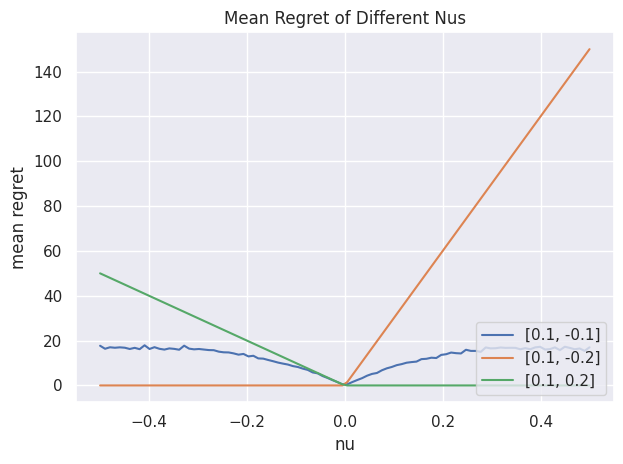

In [6]:
sns.lineplot(data=result_expectation, x="nu", y="mean regret", hue="arms")
plt.legend(loc="lower right")
plt.title("Mean Regret of Different Nus")
plt.tight_layout()
plt.savefig("linucb_regret_mean.pdf")

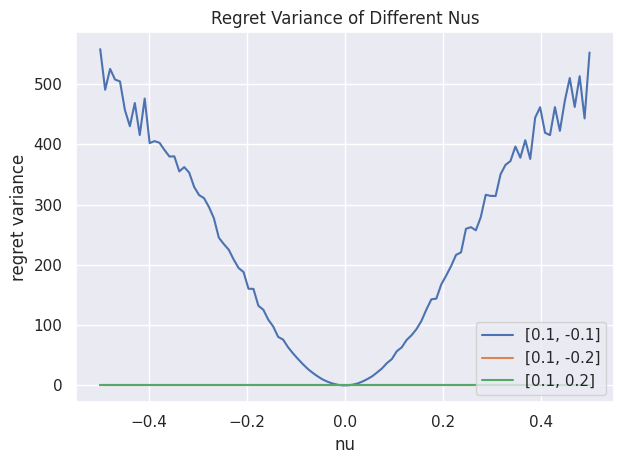

In [7]:
sns.lineplot(data=result_variance, x="nu", y="regret variance", hue="arms")
plt.legend(loc="lower right")
plt.title("Regret Variance of Different Nus")
plt.tight_layout()
plt.savefig("linucb_regret_var.pdf")